In [1]:
!pip install yfinance
!pip install transformers
!pip install wandb
!pip install beautifulsoup4


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
from pylab import mpl, plt
import math, time
import itertools
from datetime import datetime
from operator import itemgetter
from tqdm import tqdm
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
from transformers import RobertaTokenizer, RobertaModel
import torch.nn.functional as F

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!nvidia-smi

In [4]:
import wandb
wandb.login()
wandb.init(project="stock_prediction")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: visriv. Use `wandb login --relogin` to force relogin


### Hyperparams

In [5]:
no_of_days_to_lookforward = 1
no_of_days_to_lookback = 10
up_threshold = 0.015
down_threshold = -0.015
max_text_per_iter = 20
batch_size = 16
MAX_LEN = 10
num_epochs = 200
save_freq_epoch = 10
run_id = str(51)
output_path = '/content/drive/MyDrive/machine_learning/projects/xai-seq/output/run_' + run_id
# !mkdir $output_path
# !mkdir /content/drive/MyDrive/machine_learning/projects/xai-seq/output/


### Get stocks data for last N days

In [6]:
!mkdir data


mkdir: cannot create directory ‘data’: File exists


In [7]:
stock_symbols = [ 'XOM']#, 'CVX', 'COP', 'SHEL']
no_of_days = 4*365

EXPORT_DATA_FOLDER = './data/'
# !mkdir data
# Set the start and end dates for the data
# here matching it with dates of news text available
train_start = datetime.strptime('2020/01/04', '%Y/%m/%d')
train_end = datetime.strptime('2022/09/30', '%Y/%m/%d')
test_start = datetime.strptime('2022/10/01', '%Y/%m/%d')
test_end = datetime.strptime('2023/01/04', '%Y/%m/%d')


# start = datetime.datetime.now() - datetime.timedelta(days=no_of_days)
# end = datetime.datetime.now()

train_data_final = pd.DataFrame()
test_data_final = pd.DataFrame()

# Get training data
for symbol in stock_symbols:
    # Download the historical price and volume data using yfiance
    train_data_raw = yf.download(symbol, start=train_start, end=train_end)

    # Normalize features by percent of changes between today and yesterday
    pct_change_open = train_data_raw['Open'].fillna(0)#.pct_change().fillna(0)
    pct_change_high = train_data_raw['High'].fillna(0)#.pct_change().fillna(0)
    pct_change_high_over_open = (train_data_raw['High']-train_data_raw['Open'])/train_data_raw['Open']
    pct_change_low = train_data_raw['Low'].fillna(0)#.pct_change().fillna(0)
    pct_change_low_over_open = (train_data_raw['Low']-train_data_raw['Open'])/train_data_raw['Open']
    pct_change_close = train_data_raw['Close'].pct_change().fillna(0)
    close = train_data_raw['Close'].fillna(0)#.pct_change().fillna(0)
    pct_change_close_over_open = (train_data_raw['Close']-train_data_raw['Open'])/train_data_raw['Open']
    pct_change_adjclose = train_data_raw['Adj Close'].fillna(0)#.pct_change().fillna(0)
    pct_change_adjclose_over_open = (train_data_raw['Adj Close']-train_data_raw['Open'])/train_data_raw['Open']
    pct_change_volume = train_data_raw['Volume'].fillna(0)#.pct_change().fillna(0)

    # Prepare labels: 2 means the close price of tomorow is higher than today's close price; 1 is down; 0 means the movement is between up_threshold and down_threshold
    label = np.where(pct_change_close > up_threshold, 2, np.where(pct_change_close < down_threshold, 1, 0))[1:]
    label = np.append(label, 0)

    # Construct a train_data_norm data frame
    train_data_norm = pd.DataFrame({'Open_norm':pct_change_open,
                              'High_norm':pct_change_high,
                              'Low_norm': pct_change_low,
                              'Close_norm':pct_change_close,
                              'Close':close,
                              'Volume_norm':pct_change_volume,
                              'High-Open_norm':pct_change_high_over_open,
                              'Low-Open_norm':pct_change_low_over_open,
                              'Close-Open_norm':pct_change_close_over_open,
                              'Label_2up1down':label})

    # Normalize by min-max normalization after the pct normalization
    train_data_norm['Open_norm'] = train_data_norm['Open_norm'].apply(lambda x: (x - train_data_norm['Open_norm'].min()) / (train_data_norm['Open_norm'].max() - train_data_norm['Open_norm'].min()))
    train_data_norm['High_norm'] = train_data_norm['High_norm'].apply(lambda x: (x - train_data_norm['High_norm'].min()) / (train_data_norm['High_norm'].max() - train_data_norm['High_norm'].min()))
    train_data_norm['Low_norm'] = train_data_norm['Low_norm'].apply(lambda x: (x - train_data_norm['Low_norm'].min()) / (train_data_norm['Low_norm'].max() - train_data_norm['Low_norm'].min()))
    train_data_norm['Close_norm'] = train_data_norm['Close_norm'].apply(lambda x: (x - train_data_norm['Close_norm'].min()) / (train_data_norm['Close_norm'].max() - train_data_norm['Close_norm'].min()))
    train_data_norm['Close'] = train_data_norm['Close'].apply(lambda x: (x - train_data_norm['Close'].min()) / (train_data_norm['Close'].max() - train_data_norm['Close'].min()))
    train_data_norm['Volume_norm'] = train_data_norm['Volume_norm'].apply(lambda x: (x - train_data_norm['Volume_norm'].min()) / (train_data_norm['Volume_norm'].max() - train_data_norm['Volume_norm'].min()))
    train_data_norm['High-Open_norm'] = train_data_norm['High-Open_norm'].apply(lambda x: (x - train_data_norm['High-Open_norm'].min()) / (train_data_norm['High-Open_norm'].max() - train_data_norm['High-Open_norm'].min()))
    train_data_norm['Low-Open_norm'] = train_data_norm['Low-Open_norm'].apply(lambda x: (x - train_data_norm['Low-Open_norm'].min()) / (train_data_norm['Low-Open_norm'].max() - train_data_norm['Low-Open_norm'].min()))
    train_data_norm['Close-Open_norm'] = train_data_norm['Close-Open_norm'].apply(lambda x: (x - train_data_norm['Close-Open_norm'].min()) / (train_data_norm['Close-Open_norm'].max() - train_data_norm['Close-Open_norm'].min()))

    # Remove the first and the last row, becuase of NAN values
    train_data_raw = train_data_raw.iloc[1:-1]
    train_data_norm = train_data_norm.iloc[1:-1]

    train_data_raw.to_csv(EXPORT_DATA_FOLDER+symbol+'train_raw_data.csv', index=True)
    train_data_norm.to_csv(EXPORT_DATA_FOLDER+symbol+'train_norm_data.csv', index=True)

    train_data_final = pd.concat([train_data_final, train_data_norm])

# Get test data
for symbol in stock_symbols:
    # Download the historical price and volume data using yfiance
    test_data_raw = yf.download(symbol, start=test_start, end=test_end)

    # Normalize features by percent of changes between today and yesterday
    pct_change_open = test_data_raw['Open'].fillna(0)#.pct_change().fillna(0)
    pct_change_high = test_data_raw['High'].fillna(0)#.pct_change().fillna(0)
    pct_change_high_over_open = (test_data_raw['High']-test_data_raw['Open'])/test_data_raw['Open']
    pct_change_low = test_data_raw['Low'].fillna(0)#.pct_change().fillna(0)
    pct_change_low_over_open = (test_data_raw['Low']-test_data_raw['Open'])/test_data_raw['Open']
    pct_change_close = test_data_raw['Close'].pct_change().fillna(0)
    close = test_data_raw['Close'].fillna(0)#.pct_change().fillna(0)
    pct_change_close_over_open = (test_data_raw['Close']-test_data_raw['Open'])/test_data_raw['Open']
    pct_change_adjclose = test_data_raw['Adj Close'].fillna(0)#.pct_change().fillna(0)
    pct_change_adjclose_over_open = (test_data_raw['Adj Close']-test_data_raw['Open'])/test_data_raw['Open']
    pct_change_volume = test_data_raw['Volume'].fillna(0)#.pct_change().fillna(0)

    # Prepare labels: 2 means the close price of tomorow is higher than today's close price; 1 is down; 0 means the movement is between up_threshold and down_threshold
    label = np.where(pct_change_close > up_threshold, 2, np.where(pct_change_close < down_threshold, 1, 0))[1:]
    label = np.append(label, 0)

    # Construct a test_data_norm data frame
    test_data_norm = pd.DataFrame({'Open_norm':pct_change_open,
                              'High_norm':pct_change_high,
                              'Low_norm': pct_change_low,
                              'Close_norm':pct_change_close,
                              'Close':close,
                              'Volume_norm':pct_change_volume,
                              'High-Open_norm':pct_change_high_over_open,
                              'Low-Open_norm':pct_change_low_over_open,
                              'Close-Open_norm':pct_change_close_over_open,
                              'Label_2up1down':label})

    # Normalize by min-max normalization after the pct normalization
    test_data_norm['Open_norm'] = test_data_norm['Open_norm'].apply(lambda x: (x - test_data_norm['Open_norm'].min()) / (test_data_norm['Open_norm'].max() - test_data_norm['Open_norm'].min()))
    test_data_norm['High_norm'] = test_data_norm['High_norm'].apply(lambda x: (x - test_data_norm['High_norm'].min()) / (test_data_norm['High_norm'].max() - test_data_norm['High_norm'].min()))
    test_data_norm['Low_norm'] = test_data_norm['Low_norm'].apply(lambda x: (x - test_data_norm['Low_norm'].min()) / (test_data_norm['Low_norm'].max() - test_data_norm['Low_norm'].min()))
    test_data_norm['Close_norm'] = test_data_norm['Close_norm'].apply(lambda x: (x - test_data_norm['Close_norm'].min()) / (test_data_norm['Close_norm'].max() - test_data_norm['Close_norm'].min()))
    test_data_norm['Close'] = test_data_norm['Close'].apply(lambda x: (x - test_data_norm['Close'].min()) / (test_data_norm['Close'].max() - test_data_norm['Close'].min()))
    test_data_norm['Volume_norm'] = test_data_norm['Volume_norm'].apply(lambda x: (x - test_data_norm['Volume_norm'].min()) / (test_data_norm['Volume_norm'].max() - test_data_norm['Volume_norm'].min()))
    test_data_norm['High-Open_norm'] = test_data_norm['High-Open_norm'].apply(lambda x: (x - test_data_norm['High-Open_norm'].min()) / (test_data_norm['High-Open_norm'].max() - test_data_norm['High-Open_norm'].min()))
    test_data_norm['Low-Open_norm'] = test_data_norm['Low-Open_norm'].apply(lambda x: (x - test_data_norm['Low-Open_norm'].min()) / (test_data_norm['Low-Open_norm'].max() - test_data_norm['Low-Open_norm'].min()))
    test_data_norm['Close-Open_norm'] = test_data_norm['Close-Open_norm'].apply(lambda x: (x - test_data_norm['Close-Open_norm'].min()) / (test_data_norm['Close-Open_norm'].max() - test_data_norm['Close-Open_norm'].min()))

    # Remove the first and the last row, becuase of NAN values
    test_data_raw = test_data_raw.iloc[1:-1]
    test_data_norm = test_data_norm.iloc[1:-1]

    test_data_raw.to_csv(EXPORT_DATA_FOLDER+symbol+'test_raw_data.csv', index=True)
    test_data_norm.to_csv(EXPORT_DATA_FOLDER+symbol+'test_norm_data.csv', index=True)
    
    test_data_final = pd.concat([test_data_final, test_data_norm])



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


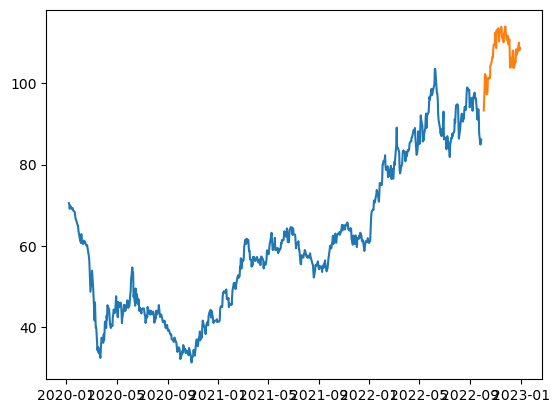

In [9]:
# train_data_raw
# train_data_final
plt.plot(train_data_raw['Open'])
plt.plot(test_data_raw['Open'])
# plt.plot(train_data_final['Close_norm'])
# plt.plot(test_data_final['Close_norm'])

In [10]:
len(train_data_raw)

688

## TODO

In [ ]:
'''
(2023-06-05)
cuda support check
//read textual data into correct shape
hyperparam tuning: number of neurons: tune to right number of neurons in FC in model
//max_text_per_iter -> code in dataloader to maintain the size

(2023-06-07)
cuda check
roberta encoder fix
multi label - how to create target label?

'''

## Prep textual data

### Crawl textual news data from internet

In [ ]:
# Import libraries
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Parameters
n = 3 #the # of article headlines displayed per ticker
tickers = ['AAPL', 'TSLA', 'AMZN']



# Get Data
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,
                  headers={'user-agent': 'Mozilla/5.0',
                                   'referer': 'https://...'})
    resp = urlopen(req)
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')

        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))

        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass


# Iterate through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text()
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]

        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]

        parsed_news.append([ticker, date, time, text])



### Read downloaded data from saved files

In [11]:
text_data_df = pd.read_csv('./data/XOM_20200401_20230401_medium (1).csv',
                           sep= ',',
                           header= 0,
                           engine='python',
                           on_bad_lines = 'skip')
text_data_df = text_data_df[['Date', 'News']]


text_data_df = text_data_df.groupby('Date')['News'].apply('$$$###'.join)

text_data_df.index = pd.to_datetime(text_data_df.index, dayfirst=True)
# text_data_df


In [12]:
all_train_df = train_data_final.join(text_data_df, how = 'left')
all_test_df = test_data_final.join(text_data_df, how = 'left')

print(all_train_df.index.min())
print(all_train_df.index.max())
print(all_test_df.index.min())
print(all_test_df.index.max())

2020-01-07 00:00:00
2022-09-28 00:00:00
2022-10-04 00:00:00
2022-12-30 00:00:00


array([[<Axes: title={'center': 'Open_norm'}>,
        <Axes: title={'center': 'High_norm'}>,
        <Axes: title={'center': 'Low_norm'}>],
       [<Axes: title={'center': 'Close_norm'}>,
        <Axes: title={'center': 'Close'}>,
        <Axes: title={'center': 'Volume_norm'}>],
       [<Axes: title={'center': 'High-Open_norm'}>,
        <Axes: title={'center': 'Low-Open_norm'}>,
        <Axes: title={'center': 'Close-Open_norm'}>],
       [<Axes: title={'center': 'Label_2up1down'}>, <Axes: >, <Axes: >]],
      dtype=object)

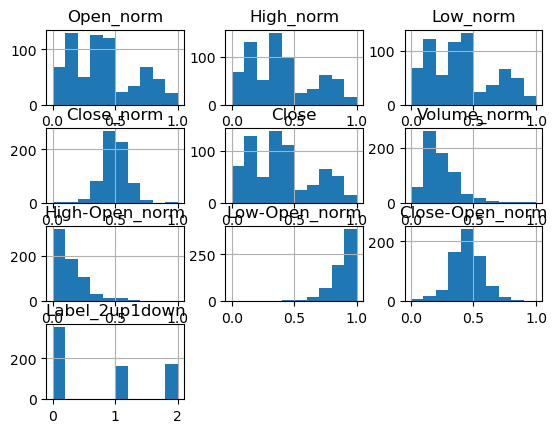

In [13]:
# check class imbalance
# train_data_norm.describe()
train_data_final.hist()

In [14]:
all_train_df

,Open_norm,High_norm,Low_norm,Close_norm,Close,Volume_norm,High-Open_norm,Low-Open_norm,Close-Open_norm,Label_2up1down,News
Date,,,,,,,,,,,
2020-01-07,0.542314,0.521109,0.540689,0.457875,0.531036,0.122365,0.002804,0.887856,0.429114,1,NaN
2020-01-08,0.536903,0.517967,0.536023,0.430191,0.516544,0.092914,0.025379,0.892927,0.366102,0,NaN
2020-01-09,0.523446,0.512638,0.528613,0.521458,0.523790,0.088649,0.108659,0.941092,0.507747,0,NaN
2020-01-10,0.534406,0.513458,0.535337,0.455050,0.515313,0.051788,0.004241,0.907498,0.374360,0,NaN
2020-01-13,0.524279,0.512228,0.535200,0.529046,0.524337,0.025064,0.095709,0.989614,0.505794,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22,0.843368,0.823610,0.829010,0.473955,0.808313,0.106026,0.049319,0.854484,0.332352,1,Exxon Mobil shuts Fos-Sur-Mer refinery in Fran...
2022-09-23,0.778163,0.753108,0.751201,0.277097,0.742412,0.257849,0.000000,0.758137,0.317074,1,Global Brake Fluid Market Research Report 2022...
2022-09-26,0.742092,0.735620,0.738027,0.407868,0.718212,0.183303,0.153690,0.904995,0.377393,2,Chevron Halting Production At Two Offshore Pla...


In [43]:
all_train[i-window_size: i, 0]
all_train[i:i+no_of_days_to_lookforward, 0]

array([0.1392896946702041], dtype=object)

### create windows and label
### also split the text seq


In [44]:
all_train = all_train_df.values

window_size = no_of_days_to_lookback

X_numerical_train = []
y_train = []
X_text_train = []
X_text_train_curr = []





for i in range(window_size, len(all_train) - no_of_days_to_lookforward + 1):
    X_numerical_train.append(all_train[i-window_size: i, 0])# :-2])

    # split and append sequence of text
    curr_seq = all_train[i-window_size: i, -1]
    for j in range(window_size):
        if (curr_seq[window_size - 1 -j] is not np.NaN):
            split_curr_seq = curr_seq[window_size - 1 -j].split('$$$###')
        else:
            split_curr_seq = []
#         X_text_train_curr = X_text_train_curr + split_curr_seq
#         else:
            

    if len(X_text_train_curr) > max_text_per_iter:
        X_text_train_curr = X_text_train_curr[:max_text_per_iter]

    X_text_train.append(X_text_train_curr)

    # target labels
    y_train.append(all_train[i:i+no_of_days_to_lookforward, 0])#-2])

X_numerical_train, y_train = np.array(X_numerical_train).astype(np.float16), np.array(y_train).astype(np.float16)
print(type(X_numerical_train))
print(type(y_train))

X_numerical_train = torch.from_numpy(X_numerical_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)#.long()

print(len(X_numerical_train))
print(len(X_text_train))
print(len(y_train))
print(X_numerical_train.shape)

print(len(X_text_train))
print(len(X_text_train[2]))
# print(X_text_train[2])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
678
678
678
torch.Size([678, 10])
678
0


In [45]:
all_test = all_test_df.values


X_numerical_test = []
y_test = []
X_text_test = []
X_text_test_curr = []

for i in range(window_size, len(all_test) - no_of_days_to_lookforward + 1):
    X_numerical_test.append(all_test[i-window_size: i, 0])#:-2])

    # split and append sequence of text (in reverse order to add the latest news first)
    curr_seq = all_test[i-window_size: i, -1]
    for j in range(window_size):
        if (curr_seq[window_size - 1 -j] is not np.NaN):
            split_curr_seq = curr_seq[window_size - 1 -j].split('$$$###')
        else:
            split_curr_seq = []
            
#         split_curr_seq = curr_seq[window_size - 1 -j].split('$$$###')
        X_text_test_curr = X_text_test_curr + split_curr_seq

    if len(X_text_test_curr) > max_text_per_iter:
        X_text_test_curr = X_text_test_curr[:max_text_per_iter]

    X_text_test.append(X_text_test_curr)

    # target labels
    y_test.append(all_test[i:i+no_of_days_to_lookforward, 0])#-2])

X_numerical_test, y_test = np.array(X_numerical_test).astype(np.float16), np.array(y_test).astype(np.float16)
print(type(X_numerical_test))
print(type(y_test))

X_numerical_test = torch.from_numpy(X_numerical_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)#.long()

print(len(X_numerical_test))
print(len(X_text_test))
print(len(y_test))
print(X_numerical_test.shape)

print(len(X_text_test))
print(len(X_text_test[2]))
# print(X_text_test[2])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
52
52
52
torch.Size([52, 10])
52
20


In [46]:
y_train

tensor([[0.5015],
        [0.4897],
        [0.4873],
        [0.4719],
        [0.4675],
        [0.4663],
        [0.4490],
        [0.4409],
        [0.4158],
        [0.4167],
        [0.4070],
        [0.4373],
        [0.4163],
        [0.4033],
        [0.4048],
        [0.4153],
        [0.4114],
        [0.4126],
        [0.3987],
        [0.3982],
        [0.3999],
        [0.3899],
        [0.3635],
        [0.3516],
        [0.3210],
        [0.2817],
        [0.2408],
        [0.2939],
        [0.3127],
        [0.2888],
        [0.2637],
        [0.2418],
        [0.1429],
        [0.2047],
        [0.1523],
        [0.1178],
        [0.1193],
        [0.0415],
        [0.0527],
        [0.0435],
        [0.0322],
        [0.0476],
        [0.0155],
        [0.0417],
        [0.0707],
        [0.0845],
        [0.0793],
        [0.0669],
        [0.0961],
        [0.0756],
        [0.1017],
        [0.1393],
        [0.1175],
        [0.1594],
        [0.1462],
        [0

## Data loader

In [47]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

tokenizer = RobertaTokenizer.from_pretrained('roberta-large', truncation=True, do_lower_case=True)

class SiameseDataloader(Dataset):

    def __init__(self, X_numerical_train, y_train, X_text_train, MAX_LEN, tokenizer):
        self.X_numerical_train = X_numerical_train
        self.X_text_train = X_text_train
        self.MAX_LEN = MAX_LEN
        self.tokenizer = tokenizer

    def __getitem__(self, index):


        input_ids = []
        attention_masks = []
        token_type_ids = []
        input_seq = []

        for sent in X_text_train[index]:
            encoded_sent = self.tokenizer.encode_plus(
                text=sent,
                add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
                max_length=self.MAX_LEN,             # Choose max length to truncate/pad
                pad_to_max_length=True,         # Pad sentence to max length
                #return_attention_mask=True      # Return attention mask
                return_token_type_ids=True
                )
            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))
            token_type_ids.append(encoded_sent.get('token_type_ids'))

        # Convert lists to tensors
        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        token_type_ids = torch.tensor(token_type_ids)


        return {
            'x_numerical': X_numerical_train[index],
            'ids': torch.tensor(input_ids, dtype=torch.long),
            'mask': torch.tensor(attention_masks, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(y_train[index])#, dtype=torch.long)
        }





    def __len__(self):
        return len(self.X_numerical_train)

In [48]:
train_set = SiameseDataloader(X_numerical_train, y_train, X_text_train, MAX_LEN, tokenizer)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)


test_set = SiameseDataloader(X_numerical_test, y_test, X_text_test, MAX_LEN, tokenizer)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [49]:
for idx, data in tqdm(enumerate(train_loader, 0)):
    if idx > 1:
        break
    print(data)

0it [00:00, ?it/s]/tmp/ipykernel_11411/2984344807.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'ids': torch.tensor(input_ids, dtype=torch.long),
/tmp/ipykernel_11411/2984344807.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mask': torch.tensor(attention_masks, dtype=torch.long),
/tmp/ipykernel_11411/2984344807.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
/tmp/ipykernel_11411/2984344807.py:46: UserWarning: To copy construct from a tensor, it is recomme

{'x_numerical': tensor([[0.5425, 0.5371, 0.5234, 0.5342, 0.5244, 0.5269, 0.5244, 0.5259, 0.5181,
         0.5127],
        [0.5371, 0.5234, 0.5342, 0.5244, 0.5269, 0.5244, 0.5259, 0.5181, 0.5127,
         0.5015],
        [0.5234, 0.5342, 0.5244, 0.5269, 0.5244, 0.5259, 0.5181, 0.5127, 0.5015,
         0.4897],
        [0.5342, 0.5244, 0.5269, 0.5244, 0.5259, 0.5181, 0.5127, 0.5015, 0.4897,
         0.4873],
        [0.5244, 0.5269, 0.5244, 0.5259, 0.5181, 0.5127, 0.5015, 0.4897, 0.4873,
         0.4719],
        [0.5269, 0.5244, 0.5259, 0.5181, 0.5127, 0.5015, 0.4897, 0.4873, 0.4719,
         0.4675],
        [0.5244, 0.5259, 0.5181, 0.5127, 0.5015, 0.4897, 0.4873, 0.4719, 0.4675,
         0.4663],
        [0.5259, 0.5181, 0.5127, 0.5015, 0.4897, 0.4873, 0.4719, 0.4675, 0.4663,
         0.4490],
        [0.5181, 0.5127, 0.5015, 0.4897, 0.4873, 0.4719, 0.4675, 0.4663, 0.4490,
         0.4409],
        [0.5127, 0.5015, 0.4897, 0.4873, 0.4719, 0.4675, 0.4663, 0.4490, 0.4409,
         0.4

## Build model


### lstm1, lstm2, roberta, concat, lrelu


In [ ]:
import torch.nn as nn

class SiameseModel11(nn.Module):
    def __init__(self, input_dim1, input_dim2,
                 hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4,
                 num_layers1, num_layers2, output_dim1, output_dim2):
        super(SiameseModel11, self).__init__()
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.num_layers1 = num_layers1
        self.num_layers2 = num_layers2
        self.output_dim1 = output_dim1
        self.output_dim2 = output_dim2

        self.roberta = RobertaModel.from_pretrained("roberta-large").to(device)

        self.lstm1 = nn.LSTM(input_dim1, hidden_dim1, num_layers1, batch_first=True)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim2, num_layers2, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim1, output_dim1)
        self.fc2 = nn.Linear(hidden_dim2, output_dim2)
        self.fc3 = nn.Linear(output_dim1+output_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, 3)
#         self.fc5 = nn.Linear(hidden_dim4, 3)
        self.lrelu = nn.LeakyReLU(0.1)



    def forward(self, x1, ids, masks, token_type_ids):
        #left tower with numerical features
        h_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        c_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        ula1, (h_out1, _) = self.lstm1(x1, (h_10, c_10))
        h_out1 = h_out1.view(-1, self.hidden_dim1)
        out1 = self.fc1(h_out1)


        # right tower with roberta on textual features
        batch_size_here = ids.shape[0]
        e2 = torch.zeros(batch_size_here, max_text_per_iter,1024).to(device)

        for k in range(ids.shape[1]):
            seq_ids = ids[:,k,:]
            seq_masks = masks[:,k,:]
            seq_token_type_ids = token_type_ids[:,k,:]

            e2k = self.roberta(input_ids= seq_ids, attention_mask=seq_masks, token_type_ids=seq_token_type_ids)
            # first 0 is for last_hidden_state: https://huggingface.co/docs/transformers/main/en/model_doc/roberta#transformers.RobertaModel.forward.returns:~:text=transformers.modeling_outputs.-,BaseModelOutputWithPoolingAndCrossAttentions%20or%20tuple(torch.FloatTensor),-A%20transformers.modeling_outputs
            # the shape of e2k[0] is (batch_size, sequence_length (<=MAX_LEN), hidden_size (=1024))
            e2k1 = e2k[0][:, 0, :]
            e2[:,k,:] = e2k1


        print(e2.shape)
        h_20 = Variable(torch.zeros(self.num_layers2, e2.size(0), self.hidden_dim2)).to(device)
        c_20 = Variable(torch.zeros(self.num_layers2, e2.size(0), self.hidden_dim2)).to(device)
        ula2, (h_out2, _) = self.lstm2(e2, (h_20, c_20))
        h_out2 = h_out2.view(-1, self.hidden_dim2)
        out2 = self.fc2(h_out2)

        # siamese merging layers
        output = torch.cat((out1, out2),1)
        output = self.lrelu(self.fc3(output))
        output = self.fc4(output)


        return output


### fcn1, fcn2, roberta, concat, lrelu

In [ ]:
import torch.nn as nn

class SiameseModel11_fcn(nn.Module):
    def __init__(self, input_dim1, input_dim2,
                 hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6):
        super(SiameseModel11_fcn, self).__init__()
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.hidden_dim5 = hidden_dim5
        self.hidden_dim6 = hidden_dim6


        self.roberta = RobertaModel.from_pretrained("roberta-large").to(device)


        self.fc11 = nn.Linear(input_dim1, hidden_dim1)
        self.fc12 = nn.Linear(hidden_dim1, hidden_dim2)

        self.fc21 = nn.Linear(input_dim2, hidden_dim3)
        self.fc22 = nn.Linear(hidden_dim3, hidden_dim4)

        self.fc31 = nn.Linear(hidden_dim2+hidden_dim4, hidden_dim5)
        self.fc32 = nn.Linear(hidden_dim5, hidden_dim6)
        self.fc33 = nn.Linear(hidden_dim6, 3)
        self.lrelu = nn.LeakyReLU(0.1)



    def forward(self, x1, ids, masks, token_type_ids):
        #left tower with numerical features

        batch_size, seq_len, embedding_size = x1.size()
        x1 = torch.reshape(x1, (batch_size, seq_len*embedding_size))

        out1 = self.fc11(x1)
        print('out1 shape:', out1.shape)

        out1 = self.fc12(out1)
        print('out1 shape:', out1.shape)

        # right tower with roberta on textual features
        batch_size_here = ids.shape[0]
        e2 = torch.zeros(batch_size_here, max_text_per_iter,1024).to(device)

        for k in range(ids.shape[1]):
            seq_ids = ids[:,k,:]
            seq_masks = masks[:,k,:]
            seq_token_type_ids = token_type_ids[:,k,:]

            e2k = self.roberta(input_ids= seq_ids, attention_mask=seq_masks, token_type_ids=seq_token_type_ids)
            # first 0 is for last_hidden_state: https://huggingface.co/docs/transformers/main/en/model_doc/roberta#transformers.RobertaModel.forward.returns:~:text=transformers.modeling_outputs.-,BaseModelOutputWithPoolingAndCrossAttentions%20or%20tuple(torch.FloatTensor),-A%20transformers.modeling_outputs
            # the shape of e2k[0] is (batch_size, sequence_length (<=MAX_LEN), hidden_size (=1024))
            e2k1 = e2k[0][:, 0, :]
            e2[:,k,:] = e2k1

        print(e2.shape)
        batch_size, seq_len, embedding_size = e2.size()
        e2 = torch.reshape(e2, (batch_size, seq_len*embedding_size))
        print(e2.shape)

        out2 = self.fc21(e2)
        print('out2 shape:', out2.shape)
        out2 = self.fc22(out2)
        print('out2 shape:', out2.shape)


        # siamese merging layers
        output = torch.cat((out1, out2),1)
        output = self.lrelu(self.fc31(output))
        output = self.lrelu(self.fc32(output))
        output = self.fc33(output)
        return output


### lstm1, mlp, relu

In [ ]:
import torch.nn as nn

class SiameseModel10(nn.Module):
    def __init__(self, input_dim1, input_dim2,
                 hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4,
                 num_layers1, num_layers2, output_dim1, output_dim2):
        super(SiameseModel10, self).__init__()
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.num_layers1 = num_layers1
        self.num_layers2 = num_layers2
        self.output_dim1 = output_dim1
        self.output_dim2 = output_dim2


        self.lstm1 = nn.LSTM(input_dim1, hidden_dim1, num_layers1, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim1, output_dim1)
        self.fc3 = nn.Linear(output_dim1, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim4, 3)



    def forward(self, x1, ids, masks, token_type_ids):
        #left tower with numerical features
        h_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        c_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        ula1, (h_out1, _) = self.lstm1(x1, (h_10, c_10))
        h_out1 = h_out1.view(-1, self.hidden_dim1)
        out1 = self.fc1(h_out1)


        # mlp layers
        output = out1
        output = F.relu(self.fc3(output))
        output = F.relu(self.fc4(output))
        output = self.fc5(output)
        return output


### lstm1, mlp, lrelu

In [50]:
import torch.nn as nn

class SiameseModel10leaky(nn.Module):
    def __init__(self, input_dim1,
                 hidden_dim1, hidden_dim3, hidden_dim4,
                 num_layers1, output_dim1):
        super(SiameseModel10leaky, self).__init__()
        self.input_dim1 = input_dim1
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.num_layers1 = num_layers1
        self.output_dim1 = output_dim1


        self.lstm1 = nn.LSTM(input_dim1, hidden_dim1, num_layers1, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim1, output_dim1)
        self.fc3 = nn.Linear(output_dim1, hidden_dim3)
        # self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim3, 1)
        self.lrelu = nn.LeakyReLU(0.1)



    def forward(self, x1, ids, masks, token_type_ids):
        #left tower with numerical features
        h_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        c_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        if (x1.dim() == 2):
            x1 = torch.unsqueeze(x1, 2)
        ula1, (h_out1, _) = self.lstm1(x1, (h_10, c_10))
        h_out1 = h_out1.view(-1, self.hidden_dim1)
        out1 = self.fc1(h_out1)


        # mlp layers
        output = out1
        output = self.lrelu(self.fc3(output))
        # output = self.lrelu(self.fc4(output))
        output = self.fc5(output)
        return output


### tranformer, mlp, relu


In [21]:
import torch.nn as nn
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=MAX_LEN):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class SiameseModel20(nn.Module):
    def __init__(self, input_dim1,
                 hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4,
                 num_layers1,  output_dim1,
                 nhead, d_transformer, dropout=0.2 ):
        super(SiameseModel20, self).__init__()

        self.input_dim1 = input_dim1
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.num_layers1 = num_layers1
        self.output_dim1 = output_dim1
        self.lrelu = nn.LeakyReLU(0.1)

        self.input_embedding  = nn.Linear(input_dim1, d_transformer)
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model=d_transformer)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_transformer,
                                                        nhead=nhead,
                                                        dropout=dropout,
                                                        batch_first=True,
                                                        dim_feedforward = 24)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers1)


        # self.lstm1 = nn.LSTM(input_dim1, hidden_dim1, num_layers1, batch_first=True)


        self.fc1 = nn.Linear(5*d_transformer, output_dim1)
        self.fc3 = nn.Linear(output_dim1, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim4, 3)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)









    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x1, ids, masks, token_type_ids):
        #left tower with numerical features
        # h_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        # c_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        # ula1, (h_out1, _) = self.lstm1(x1, (h_10, c_10))
        # h_out1 = h_out1.view(-1, self.hidden_dim1)
        # out1 = self.fc1(h_out1)

        #transformer encoder
        if self.src_mask is None or self.src_mask.size(0) != len(x1):
            device = x1.device
            mask = self._generate_square_subsequent_mask(len(x1)).to(device)
            self.src_mask = mask

        x1 = self.input_embedding(x1) # linear transformation before positional embedding

        x1 = self.pos_encoder(x1)
        output = self.transformer_encoder(x1, self.src_mask)#, self.src_mask)
        output = torch.flatten(output, start_dim=1)
        # output = output.view(-1, self.hidden_dim1)

        out1 = self.fc1(output)


        # mlp  layers
        output = out1
        output = self.lrelu(self.fc3(output))
        output = self.lrelu(self.fc4(output))
        output = self.fc5(output)
        return output



### Choose a model

In [51]:
# model = SiameseModel11(input_dim1 = 8, input_dim2 = 1024,
#                        hidden_dim1 = 20, hidden_dim2 = 768, output_dim1 = 10, output_dim2 = 256,
#                        hidden_dim3 = 10, hidden_dim4 = 8,
#                        num_layers1 = 1, num_layers2 = 1, ).to(device)

# model = SiameseModel11_fcn(input_dim1 = 8*5, input_dim2 = 1024*20,
#                  hidden_dim1 = 20, hidden_dim2 = 10, hidden_dim3 = 768, hidden_dim4 = 256, hidden_dim5 = 128, hidden_dim6 = 64 ).to(device)

model = SiameseModel10leaky(input_dim1 = 1,
                 hidden_dim1 = 20, output_dim1 = 10, hidden_dim3 = 10, hidden_dim4 = 8,
                 num_layers1 = 1).to(device)

# model = SiameseModel20(input_dim1 = 8,
#                  hidden_dim1 = 20, hidden_dim2 = 768, hidden_dim3 = 10, hidden_dim4 = 8,
#                  num_layers1 = 1, output_dim1 = 10,  nhead = 4, d_transformer = 20, dropout = 0.2).to(device)

# model = SiameseModel10(input_dim1 = 8, input_dim2 = 1024,
#                  hidden_dim1 = 20, hidden_dim2 = 768, hidden_dim3 = 10, hidden_dim4 = 8,
#                  num_layers1 = 1, num_layers2 = 1, output_dim1 = 10, output_dim2 = 256).to(device)
# for param in model.roberta.parameters():
#     param.requires_grad = False
# print(model)

'''
SiameseModel10
SiameseModel10leaky
SiameseModel20
'''




'\nSiameseModel10\nSiameseModel10leaky\nSiameseModel20\n'

In [52]:
print(x_numerical)#.dim()
print(targets)

tensor([[0.8569, 0.8774, 0.9033, 0.9189, 0.9048, 0.8989, 0.8989, 0.8833, 0.8267,
         0.8506],
        [0.8774, 0.9033, 0.9189, 0.9048, 0.8989, 0.8989, 0.8833, 0.8267, 0.8506,
         0.8623],
        [0.9033, 0.9189, 0.9048, 0.8989, 0.8989, 0.8833, 0.8267, 0.8506, 0.8623,
         0.8433],
        [0.9189, 0.9048, 0.8989, 0.8989, 0.8833, 0.8267, 0.8506, 0.8623, 0.8433,
         0.7783],
        [0.9048, 0.8989, 0.8989, 0.8833, 0.8267, 0.8506, 0.8623, 0.8433, 0.7783,
         0.7422],
        [0.8989, 0.8989, 0.8833, 0.8267, 0.8506, 0.8623, 0.8433, 0.7783, 0.7422,
         0.7520]], device='cuda:0')
tensor([[0],
        [1],
        [1],
        [2],
        [2],
        [0]], device='cuda:0')


In [53]:
y_pred = model(x_numerical, ids, masks, token_type_ids)
print(y_pred)
print(y_pred.size())


tensor([[0.2588],
        [0.2588],
        [0.2588],
        [0.2589],
        [0.2589],
        [0.2589]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([6, 1])


In [ ]:
x1 = x_numerical
batch_size, seq_len, embedding_size = x1.size()

x1 = torch.reshape(x1, (batch_size, seq_len*embedding_size))
print(x1.shape)

In [ ]:
torch.flatten(y_pred, start_dim=1).size()

## Train model

In [54]:
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_arr = np.zeros(num_epochs)

In [55]:
wandb.init(project="stock_prediction")

avg test loss in this batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg test loss in this epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg train loss in this batch,▇▁▆▂▃▂▁▂▆▄▂▅▃▄▅▁▅▄▅▇▅▆▅▃█▄▁▃▇▃▁▅▂▅▂▂▆▇▄▅
avg train loss in this epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch_id,▇▄█▃▇▃▆▄▇▃▇▂▆▁▇▃▆▂▅▁▇▃▆▂▅▁▄▂▆▁▅▁▄▂▅▁▅█▄▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
gradient_fc1.weight,▆▆▃▅▅▆▆▆▆▆▆▆▆▇▇▅███▆▆▂▃▁▆▆▆▅▆▅▅▆▆▆▆▆▆▆▇▇
gradient_fc3.weight,██▆████████████▆███▇▇▁▃▁▇██▇████████████
gradient_fc5.weight,██▅▇▇██████████▅▇▆▆▇▇▄▅▁▇██▇█▇▇█████████
gradient_lstm1.weight_hh_l0,▇▆▄▅▅▆▆▆▇▇▇▇▇▇█▅██▇▆▆▂▃▁▆▇▆▅▆▅▅▆▆▇▆▇▇▇▇█
gradient_lstm1.weight_ih_l0,█▇▆▆▆▅▄▄▄▃▃▃▃▃▂▁▁▁▂▃▅▆▆▆▆█▇▇▇▆▅▅▄▄▃▃▃▄▃▂


In [57]:
# roberta = RobertaModel.from_pretrained("roberta-large").to(device)
train_loss_record = []
wandb.watch(model, log = 'all')
for epoch in range(num_epochs):
    train_loss = []
    train_loss_sum = []
    train_correct = 0
    train_total = 0

    for idx, data in tqdm(enumerate(train_loader, 0)):
        x_numerical = data['x_numerical'].to(device, dtype = torch.float)
        ids = data['ids'].to(device, dtype = torch.long)
        masks = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)




        y_pred = model(x_numerical, ids, masks, token_type_ids)
        # print('y_pred:', y_pred)
        _, pred_label = torch.max(y_pred.data, 1)

        loss = criterion(y_pred, targets.reshape(-1))

         # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        for name, p in model.named_parameters():
            if(p.requires_grad) and ("bias" not in name):
                if p.grad is not None:
                    wandb.log({'gradient_' + name: p.grad.abs().mean().cpu().data.numpy()})
                else:
                    wandb.log({'gradient_' + name: 0})


        # plot_grad_flow(model.named_parameters(), idx, epoch) # version 1

        # Update parameters
        optimiser.step()



        train_loss.append(loss.data.cpu())
        train_loss_sum.append(loss.data.cpu())


        wandb.log({'avg train loss in this batch': loss.item(), 'epoch': epoch, 'batch_id': idx})
        # Get accuracy
        train_total += targets.reshape(-1).size(0)
        train_correct += (pred_label == targets.reshape(-1)).sum()
    train_accuracy = 100 * train_correct / train_total

    # Record at every epoch
    print('Train Loss at epoch {}: {}\n'.format(epoch, np.mean(train_loss_sum)))
    train_loss_record.append(np.mean(train_loss_sum))
    wandb.log({'avg train loss in this epoch': np.mean(train_loss_sum), 'epoch': epoch})
    wandb.log({'train accuracy in this epoch': train_accuracy, 'epoch': epoch})






    # evaluate on test set every epoch
    test_loss = []
    test_loss_sum = []

    correct = 0
    total = 0

    for idx, data in tqdm(enumerate(test_loader, 0)):
        test_x_numerical = data['x_numerical'].to(device, dtype = torch.float)
        test_ids = data['ids'].to(device, dtype = torch.long)
        test_masks = data['mask'].to(device, dtype = torch.long)
        test_token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        test_targets = data['targets'].to(device, dtype = torch.long)

        y_pred = model(test_x_numerical, test_ids, test_masks, test_token_type_ids)
        _, pred_label = torch.max(y_pred.data, 1)

#         print('y_pred:', y_pred)
        tloss = criterion(y_pred, test_targets.reshape(-1))

        test_loss.append(tloss.data.cpu())
        test_loss_sum.append(tloss.data.cpu())

        wandb.log({'avg test loss in this batch': tloss.item(), 'epoch': epoch, 'batch_id': idx})

        # Get accuracy
        total += test_targets.reshape(-1).size(0)
        correct += (pred_label == test_targets.reshape(-1)).sum()
    accuracy = 100 * correct / total

    # Record at every epoch
    print('test Loss at epoch {}: {}\n'.format(epoch, np.mean(test_loss_sum)))
    wandb.log({'avg test loss in this epoch': np.mean(test_loss_sum), 'epoch': epoch})
    wandb.log({'test accuracy in this epoch': accuracy, 'epoch': epoch})




    # save the model weights every save_freq_epoch epochs
    # if (epoch % save_freq_epoch == 0):
    #     output_model_file = output_path + '/roberta_stock_pred_' + str(epoch) + '.bin'
    #     output_vocab_file = output_path

    #     model_to_save = model
    #     torch.save(model_to_save, output_model_file)
    #     tokenizer.save_                                                                           vocabulary(output_vocab_file)









0it [00:00, ?it/s]/tmp/ipykernel_11411/2984344807.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'ids': torch.tensor(input_ids, dtype=torch.long),
/tmp/ipykernel_11411/2984344807.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mask': torch.tensor(attention_masks, dtype=torch.long),
/tmp/ipykernel_11411/2984344807.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
/tmp/ipykernel_11411/2984344807.py:46: UserWarning: To copy construct from a tensor, it is recomme

Train Loss at epoch 0: 0.08906666934490204



0it [00:00, ?it/s]/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
4it [00:00, 444.31it/s]


test Loss at epoch 0: 0.06914562731981277



43it [00:00, 202.61it/s]


Train Loss at epoch 1: 0.08517821133136749



4it [00:00, 492.19it/s]


test Loss at epoch 1: 0.07575760036706924



43it [00:00, 200.32it/s]


Train Loss at epoch 2: 0.08112531155347824



4it [00:00, 519.60it/s]


test Loss at epoch 2: 0.08300858736038208



43it [00:00, 202.48it/s]


Train Loss at epoch 3: 0.07793831080198288



4it [00:00, 540.80it/s]


test Loss at epoch 3: 0.08961793035268784



43it [00:00, 201.54it/s]


Train Loss at epoch 4: 0.07527755945920944



4it [00:00, 469.65it/s]


test Loss at epoch 4: 0.09581266343593597



43it [00:00, 203.38it/s]


Train Loss at epoch 5: 0.07295659184455872



4it [00:00, 466.81it/s]


test Loss at epoch 5: 0.10172738879919052



43it [00:00, 201.79it/s]


Train Loss at epoch 6: 0.07088394463062286



4it [00:00, 504.58it/s]


test Loss at epoch 6: 0.10742282122373581



43it [00:00, 199.55it/s]


Train Loss at epoch 7: 0.06900279223918915



4it [00:00, 470.27it/s]


test Loss at epoch 7: 0.11292397975921631



43it [00:00, 201.64it/s]


Train Loss at epoch 8: 0.06727335602045059



4it [00:00, 458.73it/s]


test Loss at epoch 8: 0.11823946982622147



43it [00:00, 201.60it/s]


Train Loss at epoch 9: 0.06566325575113297



4it [00:00, 452.90it/s]


test Loss at epoch 9: 0.12337059527635574



43it [00:00, 199.50it/s]


Train Loss at epoch 10: 0.06414362788200378



4it [00:00, 446.00it/s]


test Loss at epoch 10: 0.1283147782087326



43it [00:00, 201.24it/s]


Train Loss at epoch 11: 0.0626915842294693



4it [00:00, 457.18it/s]


test Loss at epoch 11: 0.1330544352531433



43it [00:00, 204.01it/s]


Train Loss at epoch 12: 0.06128391996026039



4it [00:00, 535.48it/s]


test Loss at epoch 12: 0.13756808638572693



43it [00:00, 200.40it/s]


Train Loss at epoch 13: 0.059896320104599



4it [00:00, 429.30it/s]


test Loss at epoch 13: 0.1418313980102539



43it [00:00, 201.65it/s]


Train Loss at epoch 14: 0.05851409584283829



4it [00:00, 488.85it/s]


test Loss at epoch 14: 0.1457800567150116



43it [00:00, 199.62it/s]


Train Loss at epoch 15: 0.05712040513753891



4it [00:00, 469.16it/s]


test Loss at epoch 15: 0.14932745695114136



43it [00:00, 203.84it/s]


Train Loss at epoch 16: 0.05566241592168808



4it [00:00, 438.08it/s]


test Loss at epoch 16: 0.15249201655387878



43it [00:00, 207.89it/s]


Train Loss at epoch 17: 0.05411061644554138



4it [00:00, 479.43it/s]


test Loss at epoch 17: 0.15524688363075256



43it [00:00, 202.83it/s]


Train Loss at epoch 18: 0.05242880433797836



4it [00:00, 459.00it/s]


test Loss at epoch 18: 0.15755760669708252



43it [00:00, 203.11it/s]


Train Loss at epoch 19: 0.05057661607861519



4it [00:00, 503.25it/s]


test Loss at epoch 19: 0.1593780517578125



43it [00:00, 213.00it/s]


Train Loss at epoch 20: 0.04850761219859123



4it [00:00, 548.85it/s]


test Loss at epoch 20: 0.16065052151679993



43it [00:00, 216.22it/s]


Train Loss at epoch 21: 0.046167995780706406



4it [00:00, 534.71it/s]


test Loss at epoch 21: 0.16130627691745758



43it [00:00, 228.21it/s]


Train Loss at epoch 22: 0.04349660128355026



4it [00:00, 438.96it/s]


test Loss at epoch 22: 0.16125960648059845



43it [00:00, 232.78it/s]


Train Loss at epoch 23: 0.040425486862659454



4it [00:00, 553.37it/s]


test Loss at epoch 23: 0.16040287911891937



43it [00:00, 230.49it/s]


Train Loss at epoch 24: 0.03688604012131691



4it [00:00, 542.97it/s]


test Loss at epoch 24: 0.158596009016037



43it [00:00, 240.50it/s]


Train Loss at epoch 25: 0.0328228622674942



4it [00:00, 474.75it/s]


test Loss at epoch 25: 0.15568546950817108



43it [00:00, 233.36it/s]


Train Loss at epoch 26: 0.02821452170610428



4it [00:00, 578.03it/s]


test Loss at epoch 26: 0.1515347957611084



43it [00:00, 231.78it/s]


Train Loss at epoch 27: 0.02314550243318081



4it [00:00, 582.32it/s]


test Loss at epoch 27: 0.14600512385368347



43it [00:00, 225.87it/s]


Train Loss at epoch 28: 0.01791302114725113



4it [00:00, 417.64it/s]


test Loss at epoch 28: 0.14213642477989197



43it [00:00, 219.34it/s]


Train Loss at epoch 29: 0.013536285609006882



4it [00:00, 452.74it/s]


test Loss at epoch 29: 0.13597574830055237



43it [00:00, 230.72it/s]


Train Loss at epoch 30: 0.009692131541669369



4it [00:00, 601.38it/s]


test Loss at epoch 30: 0.12770134210586548



43it [00:00, 235.91it/s]


Train Loss at epoch 31: 0.006738442927598953



4it [00:00, 562.28it/s]


test Loss at epoch 31: 0.12173301726579666



43it [00:00, 231.97it/s]


Train Loss at epoch 32: 0.0049725123681128025



4it [00:00, 535.11it/s]


test Loss at epoch 32: 0.11678452044725418



43it [00:00, 211.72it/s]


Train Loss at epoch 33: 0.003994944971054792



4it [00:00, 551.54it/s]


test Loss at epoch 33: 0.11400976032018661



43it [00:00, 220.62it/s]


Train Loss at epoch 34: 0.0035084718838334084



4it [00:00, 528.97it/s]


test Loss at epoch 34: 0.11290203034877777



43it [00:00, 226.44it/s]


Train Loss at epoch 35: 0.003237058874219656



4it [00:00, 537.66it/s]


test Loss at epoch 35: 0.11266990751028061



43it [00:00, 228.38it/s]


Train Loss at epoch 36: 0.0030695677269250154



4it [00:00, 534.83it/s]


test Loss at epoch 36: 0.1126408725976944



43it [00:00, 231.27it/s]


Train Loss at epoch 37: 0.002948782406747341



4it [00:00, 425.73it/s]


test Loss at epoch 37: 0.11265666037797928



43it [00:00, 224.83it/s]


Train Loss at epoch 38: 0.002857473911717534



4it [00:00, 419.84it/s]


test Loss at epoch 38: 0.11265929043292999



43it [00:00, 226.67it/s]


Train Loss at epoch 39: 0.002783403964713216



4it [00:00, 572.76it/s]


test Loss at epoch 39: 0.11274265497922897



43it [00:00, 223.26it/s]


Train Loss at epoch 40: 0.0027298384811729193



4it [00:00, 482.30it/s]


test Loss at epoch 40: 0.11274770647287369



43it [00:00, 234.86it/s]


Train Loss at epoch 41: 0.0026890637818723917



4it [00:00, 447.24it/s]


test Loss at epoch 41: 0.11280050128698349



43it [00:00, 199.22it/s]


Train Loss at epoch 42: 0.0026591909117996693



4it [00:00, 432.73it/s]


test Loss at epoch 42: 0.11280573159456253



43it [00:00, 215.82it/s]


Train Loss at epoch 43: 0.0026358691975474358



4it [00:00, 559.67it/s]


test Loss at epoch 43: 0.11281397938728333



43it [00:00, 228.26it/s]


Train Loss at epoch 44: 0.0026174827944487333



4it [00:00, 541.99it/s]


test Loss at epoch 44: 0.11284463107585907



43it [00:00, 233.91it/s]


Train Loss at epoch 45: 0.002603453118354082



4it [00:00, 598.87it/s]


test Loss at epoch 45: 0.11286721378564835



43it [00:00, 219.72it/s]


Train Loss at epoch 46: 0.002592119388282299



4it [00:00, 474.93it/s]


test Loss at epoch 46: 0.11286596953868866



43it [00:00, 229.95it/s]


Train Loss at epoch 47: 0.002583005465567112



4it [00:00, 483.42it/s]


test Loss at epoch 47: 0.11288765072822571



43it [00:00, 234.23it/s]

Train Loss at epoch 48: 0.0025751369539648294




4it [00:00, 568.45it/s]


test Loss at epoch 48: 0.11289317160844803



43it [00:00, 229.24it/s]


Train Loss at epoch 49: 0.0025682877749204636



4it [00:00, 439.17it/s]


test Loss at epoch 49: 0.11290929466485977



43it [00:00, 226.85it/s]


Train Loss at epoch 50: 0.0025626036804169416



4it [00:00, 518.30it/s]


test Loss at epoch 50: 0.11290940642356873



43it [00:00, 233.16it/s]


Train Loss at epoch 51: 0.002557779662311077



4it [00:00, 512.47it/s]


test Loss at epoch 51: 0.11289982497692108



43it [00:00, 229.28it/s]


Train Loss at epoch 52: 0.0025530443526804447



4it [00:00, 570.54it/s]


test Loss at epoch 52: 0.11289019882678986



43it [00:00, 232.13it/s]


Train Loss at epoch 53: 0.002549725817516446



4it [00:00, 503.71it/s]


test Loss at epoch 53: 0.11289100348949432



43it [00:00, 218.96it/s]


Train Loss at epoch 54: 0.002546305302530527



4it [00:00, 536.72it/s]


test Loss at epoch 54: 0.11288360506296158



43it [00:00, 228.90it/s]


Train Loss at epoch 55: 0.0025430379901081324



4it [00:00, 544.63it/s]


test Loss at epoch 55: 0.11286907643079758



43it [00:00, 228.43it/s]


Train Loss at epoch 56: 0.002539686392992735



4it [00:00, 564.07it/s]


test Loss at epoch 56: 0.11285202950239182



43it [00:00, 234.59it/s]


Train Loss at epoch 57: 0.002536801155656576



4it [00:00, 576.26it/s]


test Loss at epoch 57: 0.11283095926046371



43it [00:00, 224.38it/s]


Train Loss at epoch 58: 0.0025335936807096004



4it [00:00, 481.63it/s]


test Loss at epoch 58: 0.11281169205904007



43it [00:00, 234.32it/s]


Train Loss at epoch 59: 0.002530822530388832



4it [00:00, 589.21it/s]


test Loss at epoch 59: 0.11279039829969406



43it [00:00, 227.43it/s]


Train Loss at epoch 60: 0.002527739852666855



4it [00:00, 509.85it/s]


test Loss at epoch 60: 0.11277081072330475



43it [00:00, 225.80it/s]


Train Loss at epoch 61: 0.002525045769289136



4it [00:00, 454.06it/s]


test Loss at epoch 61: 0.1127239242196083



43it [00:00, 235.67it/s]


Train Loss at epoch 62: 0.0025219665840268135



4it [00:00, 492.52it/s]


test Loss at epoch 62: 0.11270622164011002



43it [00:00, 219.97it/s]


Train Loss at epoch 63: 0.002519435714930296



4it [00:00, 550.02it/s]


test Loss at epoch 63: 0.11268529295921326



43it [00:00, 219.59it/s]


Train Loss at epoch 64: 0.002517047571018338



4it [00:00, 470.03it/s]


test Loss at epoch 64: 0.11263565719127655



43it [00:00, 228.64it/s]


Train Loss at epoch 65: 0.0025142142549157143



4it [00:00, 443.27it/s]


test Loss at epoch 65: 0.11261679232120514



43it [00:00, 223.80it/s]


Train Loss at epoch 66: 0.002511918079108



4it [00:00, 492.43it/s]


test Loss at epoch 66: 0.11256930977106094



43it [00:00, 233.57it/s]


Train Loss at epoch 67: 0.00250925961881876



4it [00:00, 514.09it/s]


test Loss at epoch 67: 0.11255192011594772



43it [00:00, 229.29it/s]


Train Loss at epoch 68: 0.0025070796255022287



4it [00:00, 553.12it/s]


test Loss at epoch 68: 0.11253312975168228



43it [00:00, 215.29it/s]


Train Loss at epoch 69: 0.002505445620045066



4it [00:00, 577.83it/s]


test Loss at epoch 69: 0.11242181807756424



43it [00:00, 242.48it/s]


Train Loss at epoch 70: 0.0025019552558660507



4it [00:00, 450.99it/s]


test Loss at epoch 70: 0.11237703263759613



43it [00:00, 235.69it/s]


Train Loss at epoch 71: 0.0024995815474539995



4it [00:00, 508.05it/s]


test Loss at epoch 71: 0.11236267536878586



43it [00:00, 230.81it/s]


Train Loss at epoch 72: 0.002497725421562791



4it [00:00, 567.24it/s]


test Loss at epoch 72: 0.11234237998723984



43it [00:00, 224.91it/s]


Train Loss at epoch 73: 0.0024957815185189247



4it [00:00, 477.13it/s]


test Loss at epoch 73: 0.11232449114322662



43it [00:00, 227.24it/s]


Train Loss at epoch 74: 0.0024939156137406826



4it [00:00, 489.06it/s]


test Loss at epoch 74: 0.11230563372373581



43it [00:00, 228.49it/s]


Train Loss at epoch 75: 0.0024920543655753136



4it [00:00, 515.10it/s]


test Loss at epoch 75: 0.11228837072849274



43it [00:00, 222.30it/s]


Train Loss at epoch 76: 0.0024902368895709515



4it [00:00, 557.64it/s]


test Loss at epoch 76: 0.11226966232061386



43it [00:00, 224.80it/s]


Train Loss at epoch 77: 0.002488431753590703



4it [00:00, 514.62it/s]


test Loss at epoch 77: 0.11225241422653198



43it [00:00, 225.36it/s]


Train Loss at epoch 78: 0.0024866568855941296



4it [00:00, 558.63it/s]


test Loss at epoch 78: 0.11223609745502472



43it [00:00, 222.28it/s]


Train Loss at epoch 79: 0.0024850128684192896



4it [00:00, 516.89it/s]


test Loss at epoch 79: 0.11222073435783386



43it [00:00, 229.26it/s]


Train Loss at epoch 80: 0.002483345801010728



4it [00:00, 481.33it/s]


test Loss at epoch 80: 0.11220294237136841



43it [00:00, 225.43it/s]


Train Loss at epoch 81: 0.0024818223901093006



4it [00:00, 464.94it/s]


test Loss at epoch 81: 0.11215287446975708



43it [00:00, 228.79it/s]


Train Loss at epoch 82: 0.00247946591116488



4it [00:00, 428.71it/s]


test Loss at epoch 82: 0.11214780062437057



43it [00:00, 229.68it/s]


Train Loss at epoch 83: 0.0024781501851975918



4it [00:00, 568.22it/s]


test Loss at epoch 83: 0.1121319830417633



43it [00:00, 221.01it/s]


Train Loss at epoch 84: 0.0024766551796346903



4it [00:00, 442.25it/s]


test Loss at epoch 84: 0.11211109161376953



43it [00:00, 216.56it/s]


Train Loss at epoch 85: 0.0024752349127084017



4it [00:00, 445.68it/s]


test Loss at epoch 85: 0.11206148564815521



43it [00:00, 226.70it/s]


Train Loss at epoch 86: 0.002473254455253482



4it [00:00, 471.31it/s]


test Loss at epoch 86: 0.11204400658607483



43it [00:00, 226.24it/s]


Train Loss at epoch 87: 0.0024716341868042946



4it [00:00, 524.47it/s]


test Loss at epoch 87: 0.11202516406774521



43it [00:00, 232.83it/s]


Train Loss at epoch 88: 0.0024699794594198465



4it [00:00, 519.02it/s]


test Loss at epoch 88: 0.11200807243585587



43it [00:00, 232.41it/s]


Train Loss at epoch 89: 0.0024682863149791956



4it [00:00, 590.25it/s]


test Loss at epoch 89: 0.11200500279664993



43it [00:00, 224.80it/s]


Train Loss at epoch 90: 0.002466494683176279



4it [00:00, 465.83it/s]


test Loss at epoch 90: 0.11198877543210983



43it [00:00, 222.64it/s]


Train Loss at epoch 91: 0.0024650872219353914



4it [00:00, 562.20it/s]


test Loss at epoch 91: 0.11196763068437576



43it [00:00, 226.20it/s]


Train Loss at epoch 92: 0.0024634019937366247



4it [00:00, 438.77it/s]


test Loss at epoch 92: 0.11194848269224167



43it [00:00, 204.81it/s]


Train Loss at epoch 93: 0.002461866708472371



4it [00:00, 484.74it/s]


test Loss at epoch 93: 0.11192863434553146



43it [00:00, 229.56it/s]


Train Loss at epoch 94: 0.002460267161950469



4it [00:00, 480.41it/s]


test Loss at epoch 94: 0.11191071569919586



43it [00:00, 232.73it/s]


Train Loss at epoch 95: 0.0024587931111454964



4it [00:00, 558.44it/s]


test Loss at epoch 95: 0.11189049482345581



43it [00:00, 228.54it/s]


Train Loss at epoch 96: 0.002456983318552375



4it [00:00, 574.05it/s]


test Loss at epoch 96: 0.11188916116952896



43it [00:00, 222.21it/s]


Train Loss at epoch 97: 0.0024559067096561193



4it [00:00, 574.13it/s]


test Loss at epoch 97: 0.11186930537223816



43it [00:00, 220.99it/s]


Train Loss at epoch 98: 0.0024546219501644373



4it [00:00, 558.53it/s]


test Loss at epoch 98: 0.11184784024953842



43it [00:00, 227.16it/s]


Train Loss at epoch 99: 0.0024531385861337185



4it [00:00, 513.24it/s]


test Loss at epoch 99: 0.11182622611522675



43it [00:00, 223.44it/s]


Train Loss at epoch 100: 0.0024517031852155924



4it [00:00, 543.48it/s]


test Loss at epoch 100: 0.1118057519197464



43it [00:00, 224.38it/s]


Train Loss at epoch 101: 0.0024499574210494757



4it [00:00, 567.74it/s]


test Loss at epoch 101: 0.11180528253316879



43it [00:00, 236.43it/s]

Train Loss at epoch 102: 0.0024487171322107315




4it [00:00, 583.23it/s]


test Loss at epoch 102: 0.11180168390274048



43it [00:00, 235.77it/s]


Train Loss at epoch 103: 0.0024476302787661552



4it [00:00, 471.68it/s]


test Loss at epoch 103: 0.11177469789981842



43it [00:00, 220.77it/s]


Train Loss at epoch 104: 0.002446010010316968



4it [00:00, 598.67it/s]


test Loss at epoch 104: 0.11175018548965454



43it [00:00, 236.01it/s]


Train Loss at epoch 105: 0.002444291254505515



4it [00:00, 592.86it/s]


test Loss at epoch 105: 0.11174563318490982



43it [00:00, 216.01it/s]


Train Loss at epoch 106: 0.002442882629111409



4it [00:00, 525.49it/s]


test Loss at epoch 106: 0.11173136532306671



43it [00:00, 226.32it/s]


Train Loss at epoch 107: 0.002440571552142501



4it [00:00, 507.80it/s]


test Loss at epoch 107: 0.11169490218162537



43it [00:00, 233.48it/s]


Train Loss at epoch 108: 0.002438608091324568



4it [00:00, 549.80it/s]


test Loss at epoch 108: 0.11167716234922409



43it [00:00, 226.64it/s]


Train Loss at epoch 109: 0.0024371077306568623



4it [00:00, 467.77it/s]


test Loss at epoch 109: 0.11165708303451538



43it [00:00, 232.82it/s]


Train Loss at epoch 110: 0.0024357482325285673



4it [00:00, 502.21it/s]


test Loss at epoch 110: 0.11163608729839325



43it [00:00, 229.68it/s]


Train Loss at epoch 111: 0.0024341396056115627



4it [00:00, 537.28it/s]


test Loss at epoch 111: 0.11161291599273682



43it [00:00, 224.32it/s]


Train Loss at epoch 112: 0.0024326995480805635



4it [00:00, 467.71it/s]


test Loss at epoch 112: 0.11159169673919678



43it [00:00, 235.95it/s]


Train Loss at epoch 113: 0.002431012922897935



4it [00:00, 588.92it/s]


test Loss at epoch 113: 0.11160609126091003



43it [00:00, 225.97it/s]


Train Loss at epoch 114: 0.0024304583203047514



4it [00:00, 464.94it/s]


test Loss at epoch 114: 0.11159085482358932



43it [00:00, 231.80it/s]


Train Loss at epoch 115: 0.002429125364869833



4it [00:00, 537.39it/s]


test Loss at epoch 115: 0.11156467348337173



43it [00:00, 211.25it/s]


Train Loss at epoch 116: 0.0024277386255562305



4it [00:00, 573.87it/s]


test Loss at epoch 116: 0.1115289106965065



43it [00:00, 239.33it/s]


Train Loss at epoch 117: 0.0024260913487523794



4it [00:00, 438.20it/s]


test Loss at epoch 117: 0.11150594800710678



43it [00:00, 228.97it/s]


Train Loss at epoch 118: 0.0024247881956398487



4it [00:00, 442.08it/s]


test Loss at epoch 118: 0.11148537695407867



43it [00:00, 224.05it/s]


Train Loss at epoch 119: 0.002423370024189353



4it [00:00, 537.46it/s]


test Loss at epoch 119: 0.11146969348192215



43it [00:00, 230.78it/s]


Train Loss at epoch 120: 0.002422252669930458



4it [00:00, 484.40it/s]


test Loss at epoch 120: 0.11144780367612839



43it [00:00, 230.60it/s]


Train Loss at epoch 121: 0.002420992823317647



4it [00:00, 531.31it/s]


test Loss at epoch 121: 0.11142431199550629



43it [00:00, 223.53it/s]


Train Loss at epoch 122: 0.0024195595178753138



4it [00:00, 514.12it/s]


test Loss at epoch 122: 0.11140933632850647



43it [00:00, 224.88it/s]


Train Loss at epoch 123: 0.002418503165245056



4it [00:00, 455.94it/s]


test Loss at epoch 123: 0.1113872304558754



43it [00:00, 221.44it/s]


Train Loss at epoch 124: 0.00241727358661592



4it [00:00, 564.53it/s]


test Loss at epoch 124: 0.11136318743228912



43it [00:00, 230.92it/s]


Train Loss at epoch 125: 0.0024160423781722784



4it [00:00, 511.25it/s]


test Loss at epoch 125: 0.11134104430675507



43it [00:00, 236.19it/s]


Train Loss at epoch 126: 0.0024148141965270042



4it [00:00, 434.40it/s]


test Loss at epoch 126: 0.1113261878490448



43it [00:00, 209.81it/s]


Train Loss at epoch 127: 0.002414162503555417



4it [00:00, 437.65it/s]


test Loss at epoch 127: 0.1112983226776123



43it [00:00, 224.12it/s]


Train Loss at epoch 128: 0.002412923611700535



4it [00:00, 498.70it/s]


test Loss at epoch 128: 0.11127384006977081



43it [00:00, 231.57it/s]


Train Loss at epoch 129: 0.0024117245338857174



4it [00:00, 464.06it/s]


test Loss at epoch 129: 0.1112518310546875



43it [00:00, 235.52it/s]


Train Loss at epoch 130: 0.0024106381461024284



4it [00:00, 586.33it/s]


test Loss at epoch 130: 0.11122903227806091



43it [00:00, 226.44it/s]


Train Loss at epoch 131: 0.002409482840448618



4it [00:00, 482.98it/s]


test Loss at epoch 131: 0.11122208833694458



43it [00:00, 226.96it/s]


Train Loss at epoch 132: 0.0024086269550025463



4it [00:00, 548.76it/s]


test Loss at epoch 132: 0.11119940131902695



43it [00:00, 222.78it/s]


Train Loss at epoch 133: 0.0024077827110886574



4it [00:00, 583.78it/s]


test Loss at epoch 133: 0.11117205768823624



43it [00:00, 222.39it/s]


Train Loss at epoch 134: 0.002406600397080183



4it [00:00, 523.16it/s]


test Loss at epoch 134: 0.11114992201328278



43it [00:00, 228.45it/s]


Train Loss at epoch 135: 0.0024057948030531406



4it [00:00, 484.43it/s]


test Loss at epoch 135: 0.11109881848096848



43it [00:00, 226.93it/s]


Train Loss at epoch 136: 0.002404013415798545



4it [00:00, 504.30it/s]


test Loss at epoch 136: 0.1111057698726654



43it [00:00, 226.34it/s]


Train Loss at epoch 137: 0.0024038469418883324



4it [00:00, 440.36it/s]


test Loss at epoch 137: 0.11105744540691376



43it [00:00, 222.75it/s]


Train Loss at epoch 138: 0.002402346581220627



4it [00:00, 516.73it/s]


test Loss at epoch 138: 0.11105703562498093



43it [00:00, 212.25it/s]


Train Loss at epoch 139: 0.0024017628747969866



4it [00:00, 502.57it/s]


test Loss at epoch 139: 0.11103926599025726



43it [00:00, 236.11it/s]


Train Loss at epoch 140: 0.002401071134954691



4it [00:00, 463.36it/s]


test Loss at epoch 140: 0.11098582297563553



43it [00:00, 229.89it/s]


Train Loss at epoch 141: 0.0023994932416826487



4it [00:00, 549.24it/s]


test Loss at epoch 141: 0.110963374376297



43it [00:00, 222.85it/s]


Train Loss at epoch 142: 0.0023983900900930166



4it [00:00, 571.31it/s]


test Loss at epoch 142: 0.11097491532564163



43it [00:00, 234.42it/s]


Train Loss at epoch 143: 0.0023981458507478237



4it [00:00, 568.16it/s]


test Loss at epoch 143: 0.11095407605171204



43it [00:00, 227.02it/s]


Train Loss at epoch 144: 0.002397410571575165



4it [00:00, 465.21it/s]


test Loss at epoch 144: 0.11092592775821686



43it [00:00, 233.55it/s]


Train Loss at epoch 145: 0.0023965192958712578



4it [00:00, 550.25it/s]


test Loss at epoch 145: 0.11087680608034134



43it [00:00, 223.62it/s]


Train Loss at epoch 146: 0.002394895302131772



4it [00:00, 520.08it/s]


test Loss at epoch 146: 0.11088526248931885



43it [00:00, 224.06it/s]


Train Loss at epoch 147: 0.002394595416262746



4it [00:00, 479.34it/s]


test Loss at epoch 147: 0.11083798855543137



43it [00:00, 223.47it/s]


Train Loss at epoch 148: 0.002393231028690934



4it [00:00, 309.57it/s]


test Loss at epoch 148: 0.11081631481647491



43it [00:00, 215.34it/s]


Train Loss at epoch 149: 0.002392220078036189



4it [00:00, 519.16it/s]


test Loss at epoch 149: 0.110826276242733



43it [00:00, 231.35it/s]


Train Loss at epoch 150: 0.0023920119274407625



4it [00:00, 481.62it/s]


test Loss at epoch 150: 0.11080551892518997



43it [00:00, 224.74it/s]


Train Loss at epoch 151: 0.0023911253083497286



4it [00:00, 521.36it/s]


test Loss at epoch 151: 0.11078189313411713



43it [00:00, 228.21it/s]


Train Loss at epoch 152: 0.0023904137779027224



4it [00:00, 563.01it/s]


test Loss at epoch 152: 0.11075786501169205



43it [00:00, 227.50it/s]


Train Loss at epoch 153: 0.0023894794285297394



4it [00:00, 441.83it/s]


test Loss at epoch 153: 0.11074118316173553



43it [00:00, 226.35it/s]


Train Loss at epoch 154: 0.0023887234274297953



4it [00:00, 458.18it/s]


test Loss at epoch 154: 0.11072103679180145



43it [00:00, 237.13it/s]


Train Loss at epoch 155: 0.0023881071247160435



4it [00:00, 567.80it/s]


test Loss at epoch 155: 0.11067090183496475



43it [00:00, 227.02it/s]


Train Loss at epoch 156: 0.00238647498190403



4it [00:00, 426.02it/s]


test Loss at epoch 156: 0.11067909002304077



43it [00:00, 224.29it/s]


Train Loss at epoch 157: 0.0023862142115831375



4it [00:00, 505.25it/s]


test Loss at epoch 157: 0.11066285520792007



43it [00:00, 222.50it/s]


Train Loss at epoch 158: 0.002385438419878483



4it [00:00, 443.27it/s]


test Loss at epoch 158: 0.1106393039226532



43it [00:00, 233.04it/s]


Train Loss at epoch 159: 0.0023845515679568052



4it [00:00, 571.82it/s]


test Loss at epoch 159: 0.11062157154083252



43it [00:00, 223.02it/s]


Train Loss at epoch 160: 0.002383878454566002



4it [00:00, 551.70it/s]


test Loss at epoch 160: 0.1106017678976059



43it [00:00, 216.73it/s]


Train Loss at epoch 161: 0.0023830567952245474



4it [00:00, 547.10it/s]


test Loss at epoch 161: 0.1105809435248375



43it [00:00, 212.05it/s]


Train Loss at epoch 162: 0.0023822402581572533



4it [00:00, 532.61it/s]


test Loss at epoch 162: 0.11056089401245117



43it [00:00, 219.72it/s]


Train Loss at epoch 163: 0.0023816898465156555



4it [00:00, 537.99it/s]


test Loss at epoch 163: 0.11051300913095474



43it [00:00, 247.74it/s]


Train Loss at epoch 164: 0.002380277030169964



4it [00:00, 605.59it/s]


test Loss at epoch 164: 0.11051633954048157



43it [00:00, 226.77it/s]


Train Loss at epoch 165: 0.0023800174240022898



4it [00:00, 496.63it/s]


test Loss at epoch 165: 0.11049935966730118



43it [00:00, 224.32it/s]


Train Loss at epoch 166: 0.0023792667780071497



4it [00:00, 418.97it/s]


test Loss at epoch 166: 0.11047634482383728



43it [00:00, 227.21it/s]


Train Loss at epoch 167: 0.0023784267250448465



4it [00:00, 533.44it/s]


test Loss at epoch 167: 0.11045672744512558



43it [00:00, 225.09it/s]


Train Loss at epoch 168: 0.0023777401074767113



4it [00:00, 536.80it/s]


test Loss at epoch 168: 0.1104326993227005



43it [00:00, 223.85it/s]


Train Loss at epoch 169: 0.0023770539555698633



4it [00:00, 430.41it/s]


test Loss at epoch 169: 0.11038290709257126



43it [00:00, 200.38it/s]


Train Loss at epoch 170: 0.002375456504523754



4it [00:00, 443.44it/s]


test Loss at epoch 170: 0.1103917583823204



43it [00:00, 214.52it/s]


Train Loss at epoch 171: 0.0023752874694764614



4it [00:00, 444.35it/s]


test Loss at epoch 171: 0.110375314950943



43it [00:00, 225.82it/s]


Train Loss at epoch 172: 0.0023747659288346767



4it [00:00, 559.52it/s]


test Loss at epoch 172: 0.11032335460186005



43it [00:00, 226.73it/s]


Train Loss at epoch 173: 0.002373119816184044



4it [00:00, 465.53it/s]


test Loss at epoch 173: 0.11033188551664352



43it [00:00, 230.67it/s]


Train Loss at epoch 174: 0.0023729989770799875



4it [00:00, 612.53it/s]


test Loss at epoch 174: 0.1103176474571228



43it [00:00, 227.23it/s]


Train Loss at epoch 175: 0.00237241480499506



4it [00:00, 537.58it/s]


test Loss at epoch 175: 0.11029689759016037



43it [00:00, 229.91it/s]


Train Loss at epoch 176: 0.0023717964068055153



4it [00:00, 578.78it/s]


test Loss at epoch 176: 0.1102733165025711



43it [00:00, 225.23it/s]


Train Loss at epoch 177: 0.002370955189689994



4it [00:00, 403.45it/s]


test Loss at epoch 177: 0.11025286465883255



43it [00:00, 229.56it/s]


Train Loss at epoch 178: 0.0023701058235019445



4it [00:00, 547.43it/s]


test Loss at epoch 178: 0.11023347824811935



43it [00:00, 232.50it/s]


Train Loss at epoch 179: 0.0023693698458373547



4it [00:00, 430.36it/s]


test Loss at epoch 179: 0.11021281033754349



43it [00:00, 227.01it/s]


Train Loss at epoch 180: 0.002368590794503689



4it [00:00, 539.46it/s]


test Loss at epoch 180: 0.11019241809844971



43it [00:00, 224.20it/s]


Train Loss at epoch 181: 0.0023677630815654993



4it [00:00, 573.82it/s]


test Loss at epoch 181: 0.11017494648694992



43it [00:00, 232.76it/s]


Train Loss at epoch 182: 0.0023670971859246492



4it [00:00, 585.69it/s]


test Loss at epoch 182: 0.11015667021274567



43it [00:00, 235.67it/s]


Train Loss at epoch 183: 0.0023664962500333786



4it [00:00, 559.41it/s]


test Loss at epoch 183: 0.11013229936361313



43it [00:00, 226.68it/s]


Train Loss at epoch 184: 0.0023657113779336214



4it [00:00, 474.90it/s]


test Loss at epoch 184: 0.11011181026697159



43it [00:00, 228.35it/s]


Train Loss at epoch 185: 0.0023649344220757484



4it [00:00, 461.08it/s]


test Loss at epoch 185: 0.11009174585342407



43it [00:00, 209.69it/s]


Train Loss at epoch 186: 0.002364175394177437



4it [00:00, 484.61it/s]


test Loss at epoch 186: 0.11007168143987656



43it [00:00, 224.49it/s]


Train Loss at epoch 187: 0.0023634154349565506



4it [00:00, 430.16it/s]


test Loss at epoch 187: 0.11005152761936188



43it [00:00, 238.49it/s]


Train Loss at epoch 188: 0.0023626554757356644



4it [00:00, 578.15it/s]


test Loss at epoch 188: 0.11003127694129944



43it [00:00, 228.19it/s]


Train Loss at epoch 189: 0.0023620605934411287



4it [00:00, 567.53it/s]


test Loss at epoch 189: 0.11001040786504745



43it [00:00, 228.50it/s]


Train Loss at epoch 190: 0.0023612743243575096



4it [00:00, 539.03it/s]


test Loss at epoch 190: 0.10998830944299698



43it [00:00, 221.62it/s]


Train Loss at epoch 191: 0.002360490383580327



4it [00:00, 539.55it/s]


test Loss at epoch 191: 0.109967902302742



43it [00:00, 230.01it/s]


Train Loss at epoch 192: 0.002359737642109394



4it [00:00, 547.43it/s]


test Loss at epoch 192: 0.109946608543396



43it [00:00, 225.59it/s]


Train Loss at epoch 193: 0.002359016565605998



4it [00:00, 469.86it/s]


test Loss at epoch 193: 0.10992738604545593



43it [00:00, 238.69it/s]


Train Loss at epoch 194: 0.0023583127185702324



4it [00:00, 545.87it/s]


test Loss at epoch 194: 0.10987863689661026



43it [00:00, 227.23it/s]


Train Loss at epoch 195: 0.0023567432072013617



4it [00:00, 562.88it/s]


test Loss at epoch 195: 0.10988278687000275



43it [00:00, 226.28it/s]


Train Loss at epoch 196: 0.0023566565942019224



4it [00:00, 439.52it/s]


test Loss at epoch 196: 0.10986436903476715



43it [00:00, 225.58it/s]


Train Loss at epoch 197: 0.00235581467859447



4it [00:00, 539.34it/s]


test Loss at epoch 197: 0.10984072834253311



43it [00:00, 223.98it/s]


Train Loss at epoch 198: 0.002355028875172138



4it [00:00, 535.91it/s]


test Loss at epoch 198: 0.10981814563274384



43it [00:00, 221.24it/s]


Train Loss at epoch 199: 0.0023542880080640316



4it [00:00, 455.23it/s]

test Loss at epoch 199: 0.10979600250720978



## Save the model

In [ ]:
output_model_file = output_path + '/roberta_stock_pred.bin'
output_vocab_file = output_path

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)
